In [2]:
%run ./Vlad_Dissertation.ipynb

/home/renato/.virtualenvs/pps/lib/python3.11/site-packages/nbformat/__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)
/tmp/ipykernel_29566/1247435164.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In this notebook I apply different methodologies used across the literature to model SCZ. I specifically look at how parameter changes in the neurobiological network influence the psychometric function - i.e., the values of the Central Point and the Slope. I also come up with my own exploration of cross-modal links and their influence on schizophrenia.

In [3]:
n = int(200 / 0.4)
a_distances = dist = [24, 39, 54, 75, 96, 111, 126]
T = 200

### 1) Exploring E/I Imbalance

The most reliable neurobiological marker of schizophrenia is reduced GABAergic inhibition intraregionally, which I model through either excessive $L_{ex}^s$ values

In [6]:
# Start by building the inflexible parameters

Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.035e01, 6.045e02, 6.337e01, 7.194e-01
)  # feedforward and feedback
Wat, Wvt, Wav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)

In [36]:
LEXs = np.linspace(
    0, 3, 15
)  # anything larger bugs out, unless paired with weaker top-down connections as well

zt = np.zeros((len(LEXs), Mt, Nt, len(dist), n))
zv = np.zeros((len(LEXs), Mv, Nv, len(dist), n))
za = np.zeros((len(LEXs), Ma, Na, len(dist), n))
zm = np.zeros((len(LEXs), len(dist), n))

LRTs = np.zeros((len(LEXs), len(dist)))

for i in range(len(LEXs)):
    # For each L_ex see what happens
    Lt, La, Lv = Lw(LEXs[i], 0.05, 1, 4, LEXs[i], 0.05, 20, 80, LEXs[i], 0.05, 2, 8)
    (
        zt[i, :, :, :, :],
        za[i, :, :, :, :],
        zm[i, :, :],
        zv[i, :, :, :, :],
        LRTs[i, :],
    ) = experiment(
        0.4, T, dist, 5, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, 0, 0
    )

/tmp/ipykernel_29566/1941110757.py:43: RuntimeWarning: overflow encountered in exp
  psim = (fmin_m + fmax_m * np.exp((qm - qc_m) * r_m)) / (
/tmp/ipykernel_29566/1941110757.py:44: RuntimeWarning: overflow encountered in exp
  1 + np.exp((qm - qc_m) * r_m)
/tmp/ipykernel_29566/1941110757.py:43: RuntimeWarning: invalid value encountered in scalar divide
  psim = (fmin_m + fmax_m * np.exp((qm - qc_m) * r_m)) / (


In [37]:
Lcp = np.zeros(len(LEXs))
Lslope = np.zeros(len(LEXs))

for i in range(len(LEXs)):
    RTs = LRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    Lcp[i], Lslope[i] = fitting(a_distances, RTs)

np.save("drafts/Lcp.npy", Lcp)
np.save("drafts/Lslope.npy", Lslope)
np.save("drafts/LRT.npy", LRTs)

### 2)Exploring FW Pruning

Another straightforward method in the literature is synaptic pruning of feedforward weights from the unisensory regions into the multisensory neuron. 

In [58]:
Lt, La, Lv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.035e01, 6.045e02, 6.337e01, 7.194e-01
)  # feedforward and feedback
Wat, Wvt, Wav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)

In [59]:
PRs = [0.75, 1, 1.25, 2.25, 4, 5, 6, 6.5]

percpr_a = np.zeros(len(PRs))
percpr_v = np.zeros(len(PRs))

for i in range(len(PRs)):
    wpruna = prun(Wa, PRs[i])
    wprunv = prun(Wv, PRs[i])
    percpr_a[i] = np.sum(wpruna) / np.sum(Wa)
    percpr_v[i] = np.sum(wprunv) / np.sum(Wv)

print(percpr_a, percpr_v)

[1.         1.         1.         0.7380699  0.65546661 0.65546661
 0.57043239 0.57043239] [1.         1.         1.         0.95019134 0.86111541 0.82646377
 0.80566302 0.78188348]


In [11]:
zt = np.zeros((len(PRs), Mt, Nt, len(dist), n))
zv = np.zeros((len(PRs), Mv, Nv, len(dist), n))
za = np.zeros((len(PRs), Ma, Na, len(dist), n))
zm = np.zeros((len(PRs), len(dist), n))
PRRTs = np.zeros((len(PRs), len(dist)))

for i in range(len(PRs)):
    (
        zt[i, :, :, :, :],
        za[i, :, :, :, :],
        zm[i, :, :],
        zv[i, :, :, :, :],
        PRRTs[i, :],
    ) = experiment(
        0.4, T, dist, 5, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, PRs[i], 0
    )

In [12]:
PRcp = np.zeros(len(PRs))
PRslope = np.zeros(len(PRs))

for i in range(len(PRs)):
    RTs = PRRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    PRcp[i], PRslope[i] = fitting(a_distances, RTs)

np.save("drafts/PRcp.npy", PRcp)
np.save("drafts/PRslope.npy", PRslope)
np.save("drafts/PRRT.npy", PRRTs)

### 3)Exploring B_0

Paredes et al., 2021 further eplore top-down signalling issues, which they end up removing from their end model. Since my model includes crossmodal connectivity, this exploration could be of use

In [13]:
# Start by building the inflexible parameters

Wat, Wvt, Wav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)  # cross-modal
Lt, La, Lv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)  # lateral

In [82]:
FBs = np.linspace(4.5, 6.55, 15)
zt = np.zeros((len(FBs), Mt, Nt, len(dist), n))
zv = np.zeros((len(FBs), Mv, Nv, len(dist), n))
za = np.zeros((len(FBs), Ma, Na, len(dist), n))
zm = np.zeros((len(FBs), len(dist), n))
BRTs = np.zeros((len(FBs), len(dist)))

for i in range(len(FBs)):
    Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
        6.5, 6.5, 6.5, FBs[i], FBs[i], FBs[i], 1.035e01, 6.045e02, 6.337e01, 7.194e-01
    )  # feedforward and feedback
    (
        zt[i, :, :, :, :],
        za[i, :, :, :, :],
        zm[i, :, :],
        zv[i, :, :, :, :],
        BRTs[i, :],
    ) = experiment(
        0.4, T, dist, 5, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, 0, 0
    )

In [83]:
Bcp = np.zeros(len(FBs))
Bslope = np.zeros(len(FBs))

for i in range(len(FBs)):
    RTs = BRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    Bcp[i], Bslope[i] = fitting(dist, RTs)

np.save("drafts/Bcp.npy", Bcp)
np.save("drafts/Bslope.npy", Bslope)
np.save("drafts/BRT.npy", BRTs)

### 4)Exploring $\Phi_{cm}$

In [16]:
# Start by building the inflexible parameters

Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.035e01, 6.045e02, 6.337e01, 7.194e-01
)  # feedforward and feedback
Lt, La, Lv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)  # lateral

In [17]:
CMs = np.linspace(1.25, 0.125, 15)

In [18]:
zt = np.zeros((len(CMs), Mt, Nt, len(dist), n))
zv = np.zeros((len(CMs), Mv, Nv, len(dist), n))
za = np.zeros((len(CMs), Ma, Na, len(dist), n))
zm = np.zeros((len(CMs), len(dist), n))
CMRTs = np.zeros((len(CMs), len(dist)))

for i in range(len(CMs)):
    Wat, Wvt, Wav = crossmodal(CMs[i], 2, CMs[i], 2, CMs[i], 2)  # cross-modal
    (
        zt[i, :, :, :, :],
        za[i, :, :, :, :],
        zm[i, :, :],
        zv[i, :, :, :, :],
        CMRTs[i, :],
    ) = experiment(
        0.4, T, dist, 5, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, 0, 0
    )

In [19]:
CMcp = np.zeros(len(CMs))
CMslope = np.zeros(len(CMs))

for i in range(len(CMs)):
    RTs = CMRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    CMcp[i], CMslope[i] = fitting(a_distances, RTs)

np.save("drafts/CMcp.npy", CMcp)
np.save("drafts/CMslope.npy", CMslope)
np.save("drafts/CMRT.npy", CMRTs)

### 5) Exploring CM Pruning

In [76]:
Lt, La, Lv = Lw(0.15, 0.05, 1, 4, 0.15, 0.05, 20, 80, 0.15, 0.05, 2, 8)
Wt, Wa, Wv, Bt, Ba, Bv = FwFb(
    6.5, 6.5, 6.5, 6.55, 6.55, 6.55, 1.035e01, 6.045e02, 6.337e01, 7.194e-01
)  # feedforward and feedback
Wat, Wvt, Wav = crossmodal(1.3, 2, 1.3, 2, 1.3, 2)

In [77]:
CM_PRs = np.linspace(0, 1.3, 8)  # [0.75, 1, 1.25, 2.25, 4, 5, 6, 6.5]

percpr_at = np.zeros(len(CM_PRs))
percpr_vt = np.zeros(len(CM_PRs))
percpr_av = np.zeros(len(CM_PRs))

for i in range(len(CM_PRs)):
    wprunat = prun(Wat, CM_PRs[i])
    wprunvt = prun(Wvt, CM_PRs[i])
    wprunav = prun(Wav, CM_PRs[i])

    percpr_at[i] = np.sum(wprunat) / np.sum(Wat)
    percpr_vt[i] = np.sum(wprunvt) / np.sum(Wvt)
    percpr_av[i] = np.sum(wprunav) / np.sum(Wav)

print(percpr_at, percpr_vt, percpr_av)

[1.         0.85425527 0.69977593 0.58567169 0.40588838 0.27413706
 0.14778853 0.        ] [1.         0.86892987 0.71953305 0.60441575 0.42098862 0.28572316
 0.15449923 0.        ] [1.         0.79938511 0.61931687 0.48290448 0.39224797 0.22670816
 0.06397328 0.        ]


In [53]:
zt = np.zeros((len(PRs), Mt, Nt, len(dist), n))
zv = np.zeros((len(PRs), Mv, Nv, len(dist), n))
za = np.zeros((len(PRs), Ma, Na, len(dist), n))
zm = np.zeros((len(PRs), len(dist), n))
CM_PRRTs = np.zeros((len(PRs), len(dist)))

for i in range(len(PRs)):
    (
        zt[i, :, :, :, :],
        za[i, :, :, :, :],
        zm[i, :, :],
        zv[i, :, :, :, :],
        CM_PRRTs[i, :],
    ) = experiment(
        0.4, T, dist, 5, Lt, La, Lv, Wt, Wa, Wv, Bt, Ba, Bv, Wat, Wvt, Wav, 0, PRs[i]
    )

In [54]:
CM_PRcp = np.zeros(len(PRs))
CM_PRslope = np.zeros(len(PRs))

for i in range(len(PRs)):
    RTs = CM_PRRTs[i, :]

    ymin = np.min(RTs)
    ymax = np.max(RTs)

    CM_PRcp[i], CM_PRslope[i] = fitting(a_distances, RTs)

np.save("drafts/CM_PRcp.npy", PRcp)
np.save("drafts/CM_PRslope.npy", PRslope)
np.save("drafts/CM_PRRT.npy", PRRTs)

### Plots

In [17]:
# Alternatively, if you have the numpy objects and dont want to check for yourself
# FB = np.linspace(7.75, 4.5, 15)
# LEXs = np.linspace(0.175, 1.25, 15) / 0.15
#
# FBr = FB / 7.75
#
# Lcp = np.load("drafts/Lcp.npy")
# Lslope = np.load("drafts/Lslope.npy")
# LRTs = np.load("drafts/LRT.npy")
#
# Bcp = np.load("drafts/Bcp.npy")
# Bslope = np.load("drafts/Bslope.npy")
# BRTs = np.load("drafts/BRT.npy")
#
# PRcp = np.load("drafts/PRcp.npy")
# PRslope = np.load("drafts/PRslope.npy")
# PRRTs = np.load("drafts/PRRT.npy")

In [84]:
LEXs = np.linspace(0, 3, 15)
FBs = np.linspace(4.5, 6.55, 15)

In [28]:
scz_cp = 120 - 1.666 * 30
scz_slope = 1 / 0.075

print("SCZ data")
print("CP:", scz_cp)
print("Slope", scz_slope)

SCZ data
CP: 70.02000000000001
Slope 13.333333333333334


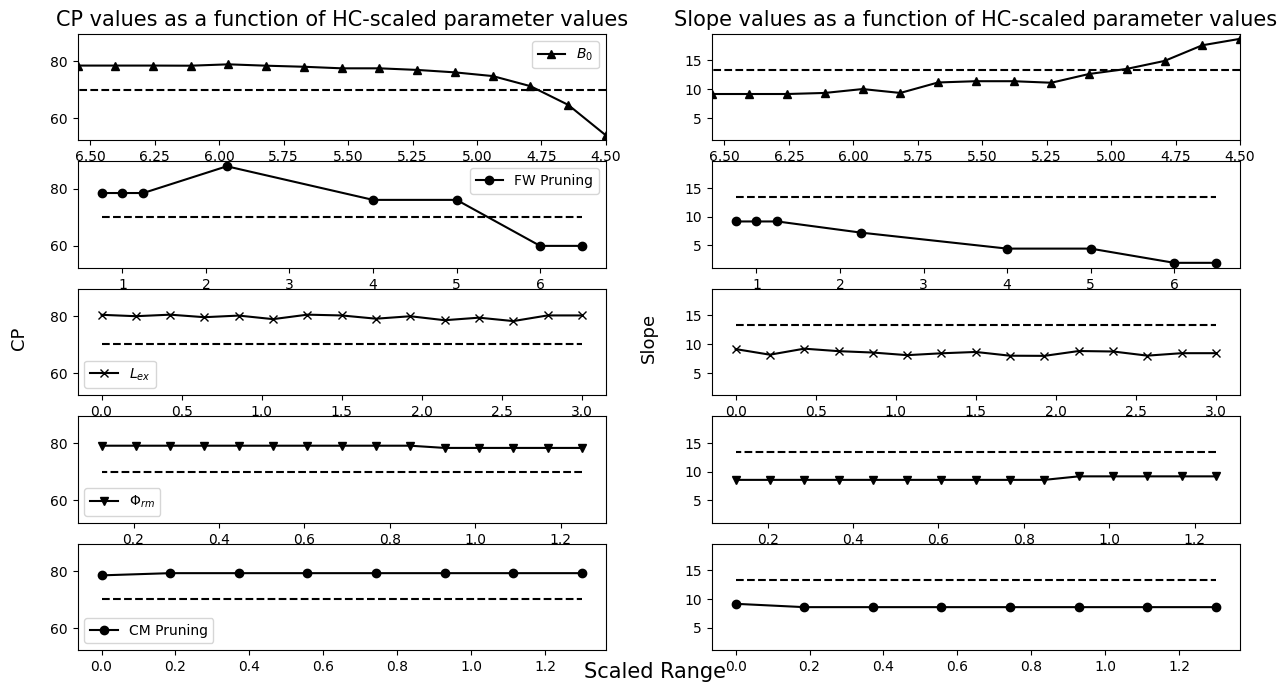

In [98]:
# Plot 2.18

fig, ax = plt.subplots(5, 2, figsize=(15, 8), sharey="col")

ax[0, 0].plot(FBs, Bcp, label="$B_0$", color="k", marker="^")
ax[0, 0].plot(FBs, np.repeat(scz_cp, len(FBs)), "--", color="k")
ax[0, 0].set_xlim(6.55, 4.5)
ax[0, 0].set_title("CP values as a function of HC-scaled parameter values", fontsize=15)
ax[0, 0].legend()

ax[0, 1].plot(FBs, Bslope, label="$B_0$", color="k", marker="^")
ax[0, 1].plot(FBs, np.repeat(scz_slope, len(FBs)), "--", color="k")
ax[0, 1].set_xlim(6.55, 4.5)
ax[0, 1].set_title(
    "Slope values as a function of HC-scaled parameter values", fontsize=15
)

ax[1, 0].plot(PRs, PRcp, label="FW Pruning", color="k", marker="o")
ax[1, 0].plot(PRs, np.repeat(scz_cp, len(PRs)), "--", color="k")
ax[1, 0].legend()

ax[1, 1].plot(PRs, PRslope, color="k", marker="o")
ax[1, 1].plot(PRs, np.repeat(scz_slope, len(PRs)), "--", color="k")

ax[2, 0].plot(LEXs, Lcp, label="$L_{ex}$", color="k", marker="x")
ax[2, 0].plot(LEXs, np.repeat(scz_cp, len(LEXs)), "--", color="k")
ax[2, 0].legend()
ax[2, 1].plot(LEXs, Lslope, color="k", marker="x")
ax[2, 1].plot(LEXs, np.repeat(scz_slope, len(LEXs)), "--", color="k")


ax[3, 0].plot(CMs, CMcp, label="$\Phi_{rm}$", color="k", marker="v")
ax[3, 0].plot(CMs, np.repeat(scz_cp, len(CMs)), "--", color="k")
ax[3, 0].legend()
ax[3, 1].plot(CMs, CMslope, color="k", marker="v")
ax[3, 1].plot(CMs, np.repeat(scz_slope, len(CMs)), "--", color="k")

ax[4, 0].plot(CM_PRs, CM_PRcp, label="CM Pruning", color="k", marker="o")
ax[4, 0].plot(CM_PRs, np.repeat(scz_cp, len(CM_PRs)), "--", color="k")
ax[4, 0].legend()

ax[4, 1].plot(CM_PRs, CM_PRslope, color="k", marker="o")
ax[4, 1].plot(CM_PRs, np.repeat(scz_slope, len(CM_PRs)), "--", color="k")


fig.text(0.51, 0.075, "Scaled Range", ha="center", fontsize=15)
fig.text(0.08, 0.5, "CP", va="center", rotation="vertical", fontsize=13)
fig.text(0.5, 0.5, "Slope", va="center", rotation="vertical", fontsize=13)

plt.show()